In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Load dataset
df = pd.read_csv("climate_youtube_with_channels.csv")

# Show first few rows
df.head()


/Users/anika/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,video_id,title,description,published_at,channel_id,channel_title,tags,view_count,like_count,comment_count,duration,category_id,live_broadcast,subscriber_count,video_count,view_count_total
0,ih88GVHyDZY,Who suffers in Cape Town’s water crisis? | Fea...,"After three years of poor rainfall, in 2018, C...",2025-04-16T14:30:26Z,UCNye-wNBqNL5ZzHSJj3l8Bg,Al Jazeera English,"['Climate Crisis', 'Environment', 'Human Right...",15098,242,44,PT46M12S,25,none,15600000,124912,5476931357
1,WgdPLrDYb6I,10 Lines on Global Warming in English | Global...,10 Lines on Global Warming in English | Global...,2025-02-18T14:15:06Z,UCkyD9FJb4jCbPiOks_pZnFw,Let's Write,"['Global Warming for students', 'Causes of Glo...",2584,25,3,PT4M43S,27,none,219000,892,46406539
2,Yurzj5gSg98,Sasha Alex Sloan - Global Warming (Lyric Video),I Blame The World // The New Album Out Now\nLi...,2022-05-13T04:00:10Z,UCMbVhQmWVSYX-o5y29XSCXg,SashaSloanVEVO,"['Global Warming', 'Pop', 'RCA Records Label',...",192885,3653,63,PT3M2S,10,none,10300,86,576050141
3,xivQ8zjqaRo,UN Sustainable Development Goals | Climate Act...,"Hello there! In this video, we talk about of t...",2017-11-02T02:42:53Z,UCn-2Vq_5GdUr1ZVnCKg7xjQ,EarthAgain,[],48346,390,20,PT1M19S,27,none,1730,17,520677
4,FlY5dj6kLl0,The Climate Action Simulation Game,The Climate Action Simulation is a highly inte...,2021-02-12T17:44:51Z,UCqIrcmlomSKTJxYC2d0bOKw,Climate Interactive,[],10195,33,0,PT1M58S,28,none,3420,206,459631


In [3]:
# Check column data types and basic structure
df.info()

# Check how many missing values are in each column
missing_counts = df.isnull().sum()
missing_percents = (missing_counts / len(df)) * 100
missing_summary = pd.DataFrame({
    "Missing Values": missing_counts,
    "% of Total": missing_percents
}).sort_values(by="Missing Values", ascending=False)

missing_summary


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568 entries, 0 to 2567
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   video_id          2568 non-null   object
 1   title             2568 non-null   object
 2   description       2426 non-null   object
 3   published_at      2568 non-null   object
 4   channel_id        2568 non-null   object
 5   channel_title     2568 non-null   object
 6   tags              2568 non-null   object
 7   view_count        2568 non-null   int64 
 8   like_count        2568 non-null   int64 
 9   comment_count     2568 non-null   int64 
 10  duration          2567 non-null   object
 11  category_id       2568 non-null   int64 
 12  live_broadcast    2568 non-null   object
 13  subscriber_count  2568 non-null   int64 
 14  video_count       2568 non-null   int64 
 15  view_count_total  2568 non-null   int64 
dtypes: int64(7), object(9)
memory usage: 321.1+ KB


,Missing Values,% of Total
description,142,5.529595
duration,1,0.038941
video_id,0,0.000000
title,0,0.000000
published_at,0,0.000000
channel_id,0,0.000000
channel_title,0,0.000000
tags,0,0.000000
view_count,0,0.000000
like_count,0,0.000000


In [4]:
# Add flag for description presence
df['has_description'] = df['description'].notnull().astype(int)

# Fill missing descriptions with empty string
df['description'] = df['description'].fillna('')

In [5]:
# Drop the row with missing duration
df = df[df['duration'].notnull()]

In [6]:
import re

def parse_duration(duration):
    pattern = re.compile(r'PT((?P<h>\d+)H)?((?P<m>\d+)M)?((?P<s>\d+)S)?')
    parts = pattern.match(duration)
    if not parts:
        return np.nan
    parts = parts.groupdict()
    hours = int(parts['h']) if parts['h'] else 0
    minutes = int(parts['m']) if parts['m'] else 0
    seconds = int(parts['s']) if parts['s'] else 0
    return hours * 3600 + minutes * 60 + seconds

df['duration_seconds'] = df['duration'].apply(parse_duration)


In [7]:
df['published_at'] = pd.to_datetime(df['published_at'])

df['publish_day'] = df['published_at'].dt.day_name()
df['publish_hour'] = df['published_at'].dt.hour
df['publish_month'] = df['published_at'].dt.month

In [8]:
# Some tags might be string representations of lists
def safe_tag_count(tag_list):
    if pd.isnull(tag_list) or tag_list == "":
        return 0
    if isinstance(tag_list, list):
        return len(tag_list)
    try:
        parsed = ast.literal_eval(tag_list)
        if isinstance(parsed, list):
            return len(parsed)
        else:
            return 0
    except:
        return 0

df['tag_count'] = df['tags'].apply(safe_tag_count)


In [9]:
def clean_description(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"<.*?>", "", text)    # remove HTML tags
    text = re.sub(r"\s+", " ", text)     # collapse whitespace
    return text.strip()

df['description_clean'] = df['description'].apply(clean_description)

In [10]:
# Drop videos with no views or where the channels have no video count
df = df[df['view_count'] > 0]
df = df[df['video_count'] > 0]

In [11]:
#Drop duplicates
df = df.drop_duplicates(subset='video_id')


In [12]:
df['view_count'] = df['view_count'].astype(int)
df['published_at'] = pd.to_datetime(df['published_at'])


The raw YouTube climate dataset underwent a comprehensive data cleaning pipeline. The process began with a systematic inspection of missing data across all variables, which informed targeted imputation and filtration strategies.

To address incomplete text data, missing values in the description field (~5.5% of records) were imputed with empty strings to preserve textual consistency, and a binary indicator (has_description) was created to explicitly track content presence. One anomalous record with a null duration was removed to maintain temporal completeness.

A key challenge addressed was the parsing of YouTube’s ISO 8601 video duration format (e.g., PT8M4S). A custom regular expression-based parser was implemented to convert durations into total seconds (duration_seconds), enabling quantitative temporal analysis. Similarly, published_at timestamps were standardized using datetime parsing and then decomposed into granular temporal features including day of the week (publish_day), hour of day (publish_hour), and calendar month (publish_month) to support time-aware modeling.

Tags, often stored as stringified lists with inconsistencies and sparsity, were sanitized using Python’s abstract syntax tree parser to compute a robust tag_count feature. This allowed for the extraction of engagement-related signals while accounting for structural variability in the raw data.

To mitigate noise and enhance quality, the dataset was filtered to exclude videos with zero view counts or originating from channels reporting zero video uploads — both indicative of anomalous or non-engaging content. Duplicate entries were also removed based on the unique video_id.

Textual fields were further refined: the description field was normalized using a regex-based cleaning function to remove URLs, HTML artifacts, and superfluous whitespace, resulting in a clean text field (description_clean) optimized for potential downstream NLP processing.

Finally, key numeric and temporal fields such as view_count and published_at were explicitly cast to appropriate data types (int and datetime64) to eliminate potential type-related ambiguities during modeling.

This cleaning process not only ensured dataset integrity but also laid the foundation for sophisticated feature engineering and advanced predictive modeling tasks.

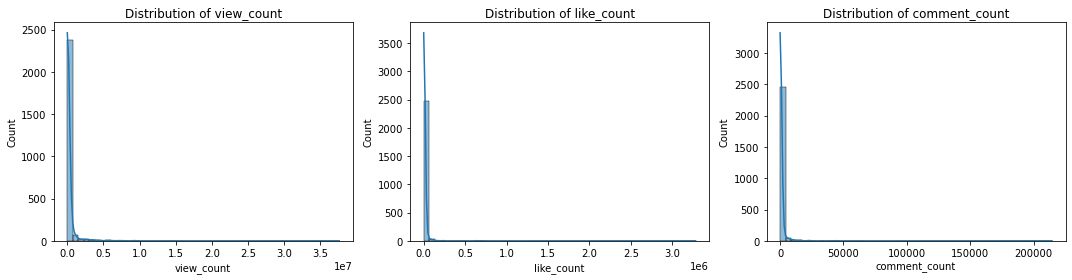

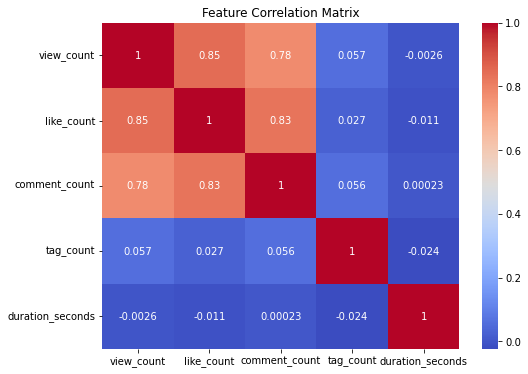

In [13]:
# Summary statistics for numeric columns
df.describe()

# Distribution of views, likes, comments
plt.figure(figsize=(15, 4))
for i, col in enumerate(['view_count', 'like_count', 'comment_count']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['view_count', 'like_count', 'comment_count', 'tag_count', 'duration_seconds']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


view_count, like_count, and comment_count all have Heavily right-skewed distributions — classic long-tail behavior.

Majority of climate videos receive relatively low interaction, while a few go viral.

This suggests we may need log transformations or outlier handling before modeling

Strong correlation between:

view_count ↔ like_count (0.85)

like_count ↔ comment_count (0.83)

These metrics track together well — makes sense since viral videos tend to score high across all metrics.

Weak to no correlation:

tag_count and duration_seconds show little relationship with engagement

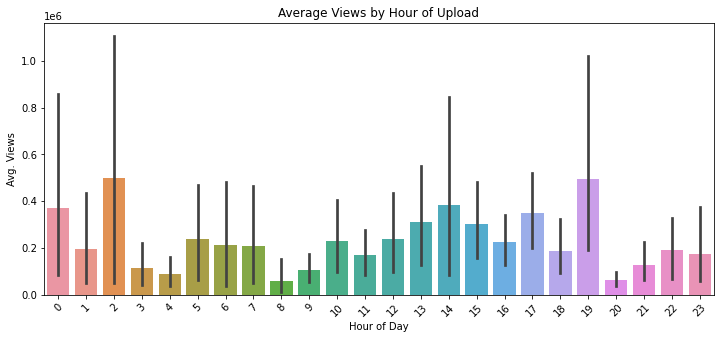

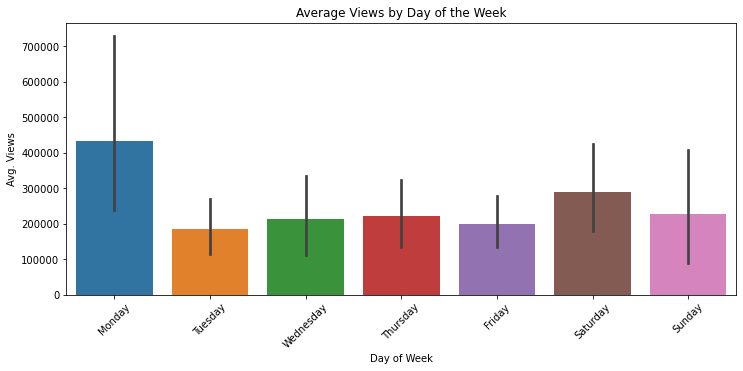

In [14]:
# Average views by hour of day
plt.figure(figsize=(12, 5))
sns.barplot(x='publish_hour', y='view_count', data=df)
plt.title("Average Views by Hour of Upload")
plt.ylabel("Avg. Views")
plt.xlabel("Hour of Day")
plt.xticks(rotation=45)
plt.show()

# Average views by day of the week
plt.figure(figsize=(12, 5))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='publish_day', y='view_count', data=df, order=order)
plt.title("Average Views by Day of the Week")
plt.ylabel("Avg. Views")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.show()


There’s high variance across hours, but some notable spikes:

Around 1–3 AM and 6–7 PM (18–19) see higher average views.

Uploading in late evening or early morning might be capturing global time zones or late-night browsing behavior.

Error bars (standard deviation) are large — this suggests a few viral videos may be skewing the averages.

Worth exploring a log transformation or using median views to reduce outlier impact.

Interpretation: Climate videos uploaded in the evening or early morning tend to perform better on average, though there's a lot of variability.

Monday stands out as the strongest day for video performance.

Tuesday to Friday are relatively flat with lower average views.

Saturday also sees an increase, likely due to weekend viewer availability.

Interpretation: Videos uploaded on Mondays or Saturdays may receive more initial engagement — possibly tied to viewers starting the week or catching up on content during weekends.

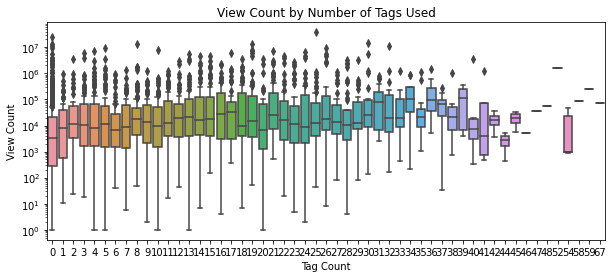

In [15]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='tag_count', y='view_count', data=df)
plt.title("View Count by Number of Tags Used")
plt.ylabel("View Count")
plt.xlabel("Tag Count")
plt.yscale('log')
plt.show()

Using more tags is generally associated with higher visibility and engagement, likely due to improved discoverability in YouTube’s algorithm.

However, after ~30 tags, the marginal benefit drops off — possibly due to tag stuffing or irrelevant tagging, which might dilute SEO effectiveness.

Some of the very high tag counts (40–60) have low or inconsistent views, likely from small channels overusing tags without a strong subscriber base.


In [17]:
df[['title', 'view_count', 'like_count', 'comment_count']].sort_values(by='view_count', ascending=False).head(10)


,title,view_count,like_count,comment_count
1588,Dear Future Generations: Sorry (2025),37591013,3280480,214445
796,Let HIM COOK 🔥 #skit #funny #climatechange,24289275,1379166,10418
253,Arctic Sinkholes I Full Documentary I NOVA I PBS,14726876,123207,14997
2113,Can YOU Fix Climate Change?,13706830,713211,62693
1141,CALLING ALL BLINKS: CLIMATE ACTION IN YOUR ARE...,13151655,1155615,39917
2372,climate change challenge,13009785,332366,13723
646,We WILL Fix Climate Change!,11628280,620441,43989
2475,Who Is Responsible For Climate Change? – Who N...,10952099,396731,45553
560,Greta Thunberg to world leaders: 'How dare you...,9322457,112420,42204
2507,Do we Need Nuclear Energy to Stop Climate Change?,9228901,321809,26265


# Cluster climate-related videos based on their title and tag content 

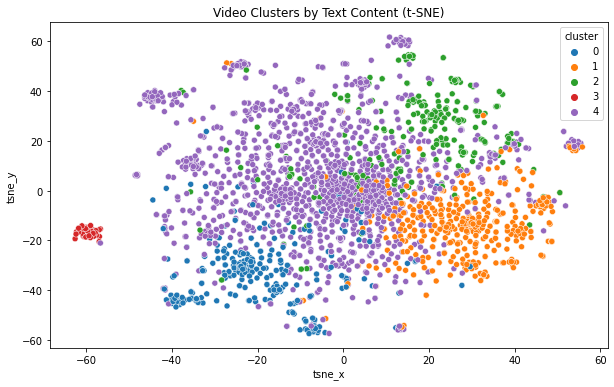

In [18]:
def join_tags(tags):
    try:
        parsed = ast.literal_eval(tags)
        if isinstance(parsed, list):
            return " ".join(parsed)
    except:
        return ""
    return ""

# Combine title and tags into a single text column
df['tags_clean'] = df['tags'].apply(join_tags)
df['text'] = df['title'] + " " + df['tags_clean']

#TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf.fit_transform(df['text'])

#KMeans Clustering
from sklearn.cluster import KMeans

n_clusters = 5  # Try 5-8 to start
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_tfidf)

#Visualize Clusters
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

df['tsne_x'] = X_tsne[:, 0]
df['tsne_y'] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='cluster', data=df, palette='tab10')
plt.title("Video Clusters by Text Content (t-SNE)")
plt.show()


In [22]:
df = df.reset_index(drop=True)
# Re-fit TF-IDF to keep terms
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = vectorizer.fit_transform(df['text'])
terms = vectorizer.get_feature_names()

# Get top TF-IDF terms for each cluster
from sklearn.preprocessing import normalize
X_tfidf_norm = normalize(X_tfidf)

# For each cluster, average the TF-IDF scores
cluster_centroids = []
for cluster_id in sorted(df['cluster'].unique()):
    indices = df[df['cluster'] == cluster_id].index
    cluster_vecs = X_tfidf_norm[indices]
    centroid = cluster_vecs.mean(axis=0)
    cluster_centroids.append(np.array(centroid).flatten())

# Top words per cluster
top_n = 10
for i, centroid in enumerate(cluster_centroids):
    top_indices = np.argsort(centroid)[::-1][:top_n]
    top_words = [terms[idx] for idx in top_indices]
    print(f"\nCluster {i}:")
    print(", ".join(top_words))



Cluster 0:
warming, global, essay, effect, science, greenhouse, english, model, climate, earth

Cluster 1:
carbon, emissions, footprint, reduce, reducing, energy, zero, net, climate, news

Cluster 2:
news, climate, change, crisis, bbc, world, live, today, breaking, abc

Cluster 3:
drawing, poster, warming, global, easy, stop, save, environment, day, earth

Cluster 4:
climate, change, action, crisis, global, science, earth, warming, ted, environment


Some potential clustering interpretations:

0	Scientific/Educational	"essay", "effect", "greenhouse", "model" → these sound like videos explaining concepts

1	Personal Carbon Reduction	"footprint", "reduce", "net zero" → likely focused on lifestyle/environmentalism

2	News & Live Events	"bbc", "breaking", "world", "today" → live coverage or news clips

3	Kid/School Content	"drawing", "poster", "easy", "stop" → possibly content for education or awareness campaigns

4	Activism & Advocacy	"action", "ted", "crisis" → inspirational or activist content, possibly TED talks or campaigns